In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ""})
sns.set(rc={'figure.figsize':(16,9)})

Этот датасет представляет собой стоимость домов в тысячах долларов в Калифорнии в зависимости от его характеристик:
- Средний доход в округе.
- Возраст дома.
- Среднее количество комнат в доме.
- Среднее количество спальных комнат в доме.
- Население в округе.
- Широта округа.
- Долгота Округа.

In [2]:
# загрузка данных
data = fetch_california_housing()
df = pd.DataFrame(data['data'],columns = data['feature_names'])
df[data['target_names']] = data['target']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Предпросмотр данных, из которых видно, что нет пропусков в данных, а также категориальных признаков.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Проверка на адекватность данных, например нет отрицательной величины популяции или возраста дома.

In [4]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Корреляционная матрица.

<AxesSubplot:>

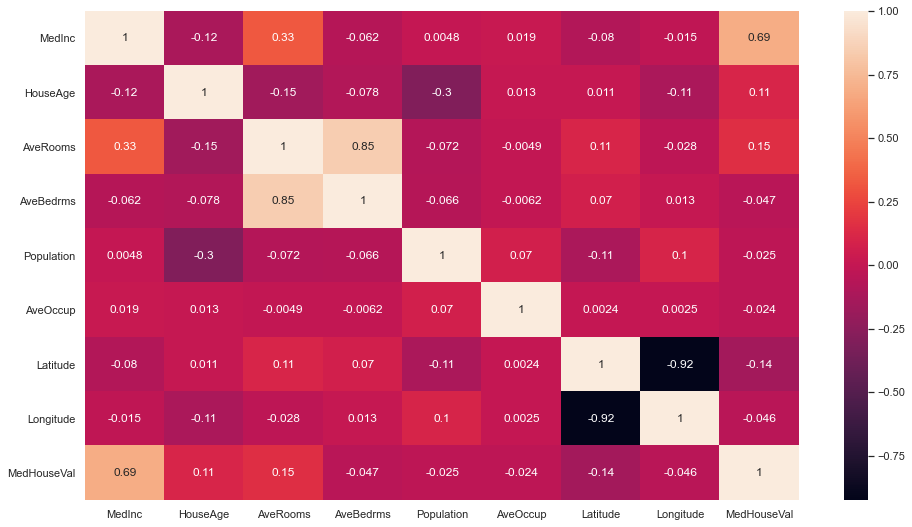

In [5]:
sns.heatmap(df.corr(), annot=True)

Из гистограмм и расчитанных квантилей видим распределения для каждого признака, а также что есть дома с аномальными характерисиками. Из-за чего возникает необходимость фильтрации данных или использование алгоритмов устойчивых к выбросам.

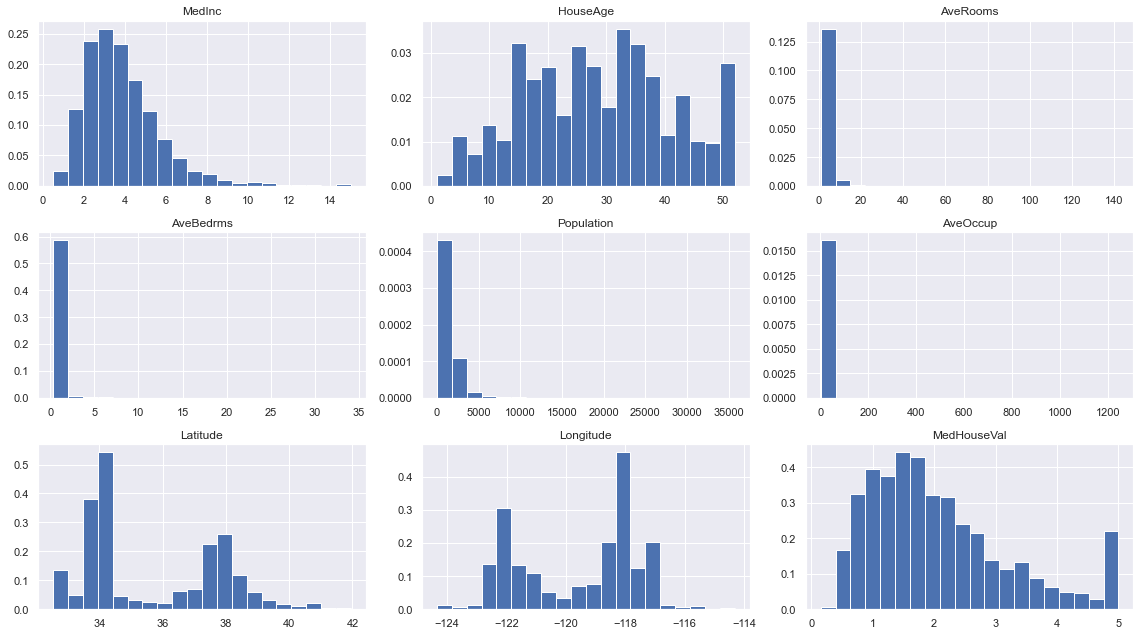

In [6]:
df.hist(bins=20,density=True)
plt.tight_layout()

In [7]:
df.quantile(0.999)

MedInc            15.000100
HouseAge          52.000000
AveRooms          34.199698
AveBedrms          6.617232
Population     10372.681000
AveOccup          13.630443
Latitude          41.753610
Longitude       -114.646390
MedHouseVal        5.000010
Name: 0.999, dtype: float64

Из графика видно, стоимость дома варьируется от географического положения.

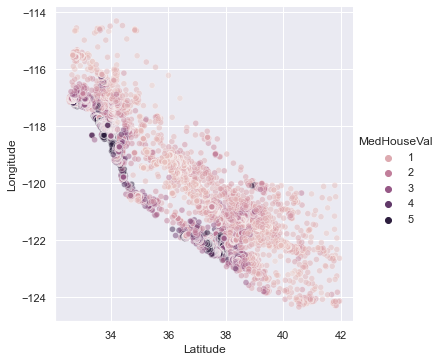

In [8]:
sns.relplot(data = df,
           x='Latitude', y='Longitude',
           hue='MedHouseVal', alpha=.5)

Расширяем признаковое пространство, для получения признаков, которые могут иметь корреляцию с рельной стоимостью дома.


<AxesSubplot:>

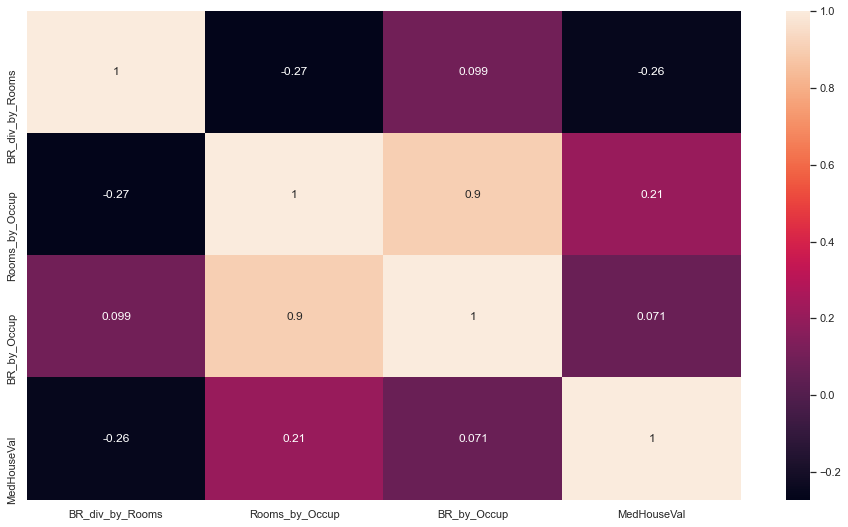

In [9]:
df_extended = pd.DataFrame()
df_extended['BR_div_by_Rooms'] = df['AveBedrms']/df['AveRooms']
df_extended['Rooms_by_Occup'] = df['AveRooms']/df['AveOccup']
df_extended['BR_by_Occup'] = df['AveBedrms']/df['AveOccup']

df_extended['MedHouseVal'] = df['MedHouseVal']

sns.heatmap(df_extended.corr(), annot=True)

Финальная вид df для обучения.

In [10]:
df = pd.concat([df,df_extended.drop(columns='MedHouseVal')],axis=1,copy=False)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,BR_div_by_Rooms,Rooms_by_Occup,BR_by_Occup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.146591,2.732919,0.400621
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.155797,2.956685,0.460641
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0.129516,2.957661,0.383065
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.184458,2.283154,0.421147
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.172096,2.879646,0.495575


Разбиение данных на обучающую и тестовую выборку.

In [11]:
train_df,test_df = train_test_split(df,train_size=0.8)

In [12]:
train_df.to_csv('data/train_data.csv')
test_df.to_csv('data/test_data.csv')

Инизиализация модели и ее обучение. В качестве модели выбран градиентный бустинг на деревьях, из-за его точности устойчивости к выбросам, отсутсвие необходимости нормализации входных данных (входные данные не имеют нормальное распределение, также имеют разный порядок). В качестве метрики выбран MSE.

In [13]:
# инициализация модели
model = xgb.XGBRegressor(objective='reg:squarederror')

#изменяемые параметры
parameters = {
    'max_depth': range (2, 6, 1),
    'n_estimators': range(50, 551, 50),
    'learning_rate': [0.1, 0.01, 0.001, 0.0001,]
}

#поиск по седке параметров
grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 1,
    cv = 5,
    verbose=True
)

grid_search.fit(train_df.drop(columns='MedHouseVal'), train_df['MedHouseVal'])

Fitting 5 folds for each of 176 candidates, totalling 880 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
            

Результаты поиска параметров модели показывает, что лучшие результаты получены при крайних значениях пораметров, имееет смысл в расширении сетки поиска.

In [14]:
print('Лучшие параметры: ',grid_search.best_params_) 
print('Лучшее значение метрики: ', grid_search.best_score_)

Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 550}
Лучшее значение метрики:  -0.21007604123541065


Повторное обучение.

In [15]:
#изменяемые параметры
parameters = {
    'max_depth': range (3, 7, 1),
    'n_estimators': range(500, 801, 50),
    'learning_rate': [0.3, 0.1, 0.01, ]
}

#поиск по седке параметров
grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 1,
    cv = 5,
    verbose=True
)

grid_search.fit(train_df.drop(columns='MedHouseVal'), train_df['MedHouseVal'])
print('Лучшие параметры: ',grid_search.best_params_) 
print('Лучшее значение метрики: ', grid_search.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 750}
Лучшее значение метрики:  -0.2060163935002539


Сильно не повышается точность модели, из-за чего обучение останавливается.

In [16]:
model = grid_search.best_estimator_

In [17]:
path = 'data/model.json'
model.save_model(path)

Проверка модели на тестовых данных (метрика -  MSE)

In [18]:
preds = model.predict(test_df.drop(columns='MedHouseVal'))
mean_squared_error(preds, test_df['MedHouseVal'])

0.19782484056963834

Отбор признаков, из которого видно, что они были информативны.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

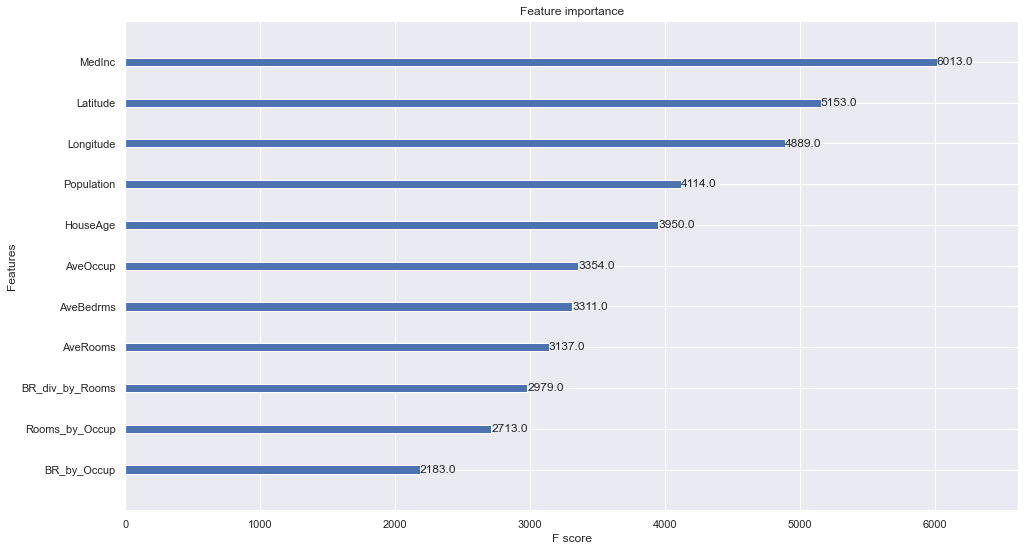

In [19]:
xgb.plot_importance(model)